## 1. Importing packages and libraries:

In [ ]:
# General packages
import time

# Main data handling and visualization packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Scikit-Learn preprocessing modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Scikit-Learn ML + xgboost modules
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import xgboost as xgboost

# Tensorflow modules
import tensorflow as tf
import keras_tuner as kt

## 2. Reading training data:



In [ ]:
train_label = pd.read_csv("contents/train_label.csv")
train_feat = pd.read_csv("contents/train_feat.csv")
trainvaltes_feat = pd.read_csv("contents/trainvaltes_feat.csv")
trainvaltes_label= pd.read_csv("contents/trainvaltes_label.csv")
test_feat= pd.read_csv("contents/test_feat.csv")

# 3. Define model space for ML methods and NN architectures

3.1. ML models:

In [ ]:
# function to create parameter grids

def make_param(param_dict, model):
    for elem in param_dict.copy():
        if elem == 'n_components':
            param_dict['pca'+'__'+elem] = param_dict.pop(elem)
        else:
            param_dict[model+'__'+elem] = param_dict.pop(elem)
    return param_dict

In [ ]:
# Machine learning models and their hyperparameter search space

# Models
svr = SVR(kernel='rbf')
rfr = RandomForestRegressor(n_estimators=100)
kneigh = KNeighborsRegressor(n_neighbors=5)
gbr = GradientBoostingRegressor(n_estimators=200)
xgb = xgboost.XGBRegressor(device='cpu', eval_metric='mae', seed=0)
ada = AdaBoostRegressor(random_state=42)
hgbr = HistGradientBoostingRegressor(random_state=42)

In [ ]:
# Model space
EstimatorStr = {1: 'svr', 2: 'rfr', 3: 'kneigh', 4: 'gbr', 5: 'xgb', 6: 'tbd'}
EstimatorMdl = {1: svr, 2: rfr, 3: kneigh, 4: gbr, 5: xgb}

In [ ]:
# Tuned hyperparameter sets
param_single_svr = {'svr__C': 1, 'svr__degree': 3, 'svr__kernel': 'rbf'}
param_single_rfr = {'randomforestregressor__n_estimators': 100}
param_single_kneigh = {'kneighborsregressor__n_neighbors': 5}
param_single_gbr = {'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__max_depth': 3}
param_single_xgb = {'xgbregressor__n_estimators': 100, 'xgbregressor__max_depth': 3}
param_single_ada = {}
param_single_hgbr = {}

In [ ]:
# Hyperparameter search sets for machine learning methods
param_grid_svr = {'svr__C': np.linspace(1, 10, 5), 'svr__degree':  np.arange(2, 6, 1), 'svr__kernel': ['rbf']}
param_grid_rfr = {'randomforestregressor__n_estimators': np.arange(50, 250, 50)}
param_grid_kneigh = {'kneighborsregressor__n_neighbors': np.arange(2, 12, 2)}
param_grid_gbr = {'gradientboostingregressor__n_estimators': np.arange(50, 250, 50),
                  'gradientboostingregressor__max_depth': np.arange(2, 6, 1)}
param_grid_xgb = {'xgbregressor__n_estimators': np.arange(50, 250, 50), 'xgbregressor__max_depth': np.arange(2, 6, 1)}
param_grid_ada = {}
param_grid_hgbr = {}

3.2. Deep Learning Models:

In [ ]:
def build_network(hp):
    # define the sets of inputs
    inp = tf.keras.Input(shape=(len(train_feat.columns),), name='input')
    x = inp

    # apply FC layers and then a regression
    reg = None #tf.keras.regularizers.L2(hp.Float(name='l2', min_value=5e-4, max_value=5e-2, default=0.025))
    do = hp.Float(name='dropout', min_value=0.04, max_value=0.04, default=0.04)
    layers = hp.Int(name='layers', min_value=5, max_value=5, default=5)
    units = hp.Int(name='units', min_value=768, max_value=768, step = 128, default=768)
    act = 'relu'
    ki = 'he_normal'
    for i, units in enumerate([units for i in range(layers)]):
        x = tf.keras.layers.Dense(units, activation=act, kernel_regularizer=reg, kernel_initializer=ki,
                                  name=f'fc{i+1}')(x)
        x = tf.keras.layers.Dropout(do, name=f'do{i+1}')(x)
    out = tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=reg, kernel_initializer=ki,
                                name='regression')(x)

    model = tf.keras.Model(inputs=inp, outputs=out, name='DNN_network')

    lr_tune = hp.Float(name='learning_rate', min_value=5e-5, max_value=5e-3, sampling='log', default=6e-4)
    optimizer = tf.keras.optimizers.Adam(lr_tune)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.msle, metrics=['msle'])
    return model

with strategy.scope():
    model_nn = build_network(kt.HyperParameters())

model_nn.summary()

Model: "DNN_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 103)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 768)            │        79,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do1 (Dropout)                   │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do2 (Dropout)                   │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do3 (Dropout)                   │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do4 (Dropout)                   │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc5 (Dense)                     │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do5 (Dropout)                   │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression (Dense)              │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,443,009 (9.32 MB)

 Trainable params: 2,443,009 (9.32 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Training

Owing to the large amount of samples, the classical ML methods does not seem to be a good option. However for experimenting purposes I have included an ML part as well where one can experiment with several ML algorithm. For submission only NN network is activated.

In [ ]:
# Training configurations
TUNING = False
TRAINING = True
NN = True
ML = False

In [ ]:
# Hyperparameter search or single fitting for ML methods

for i_TypEstimator in [5]: # Choosing models to fit or tune {1: svc, 2: rfc, 3: kneigh, 4: gbc, 5: xgb} 1, 2, 3, 4, 5
    if ML:
        if TUNING:
            param = globals()[f'param_grid_{EstimatorStr[i_TypEstimator]}']
        else:
            param = globals()[f'param_single_{EstimatorStr[i_TypEstimator]}']

        if ('pca__n_components' in param.keys() and param['pca__n_components']):
            param.pop('pca__n_components')
            pl = make_pipeline(EstimatorMdl[i_TypEstimator])
        elif 'pca__n_components' not in param.keys():
            pl = make_pipeline(EstimatorMdl[i_TypEstimator])
        else:
            pca = PCA(random_state=42)
            pl = make_pipeline(pca, EstimatorMdl[i_TypEstimator])
        pipeline = deepcopy(pl)

        if TUNING:
            grid = GridSearchCV(pipeline, param, scoring='neg_root_mean_squared_error', verbose=3, cv=gen_cv)
            grid.fit(trainvaltes_feat, np.array(trainvaltes_label).ravel())
            print(grid.best_params_)
            model_ml = grid.best_estimator_
        else:
            pipeline.set_params(**param)
            pipeline.fit(train_feat, np.array(train_label).ravel())
            model_ml = pipeline

        # Custom metric
        train_preds = np.clip(model_ml.predict(train_feat), a_min=0, a_max=None)
        val_preds = np.clip(model_ml.predict(val_feat), a_min=0, a_max=None)
        train_msle = np.sqrt(mean_squared_log_error(train_preds, np.array(train_label).ravel()))
        val_msle = np.sqrt(mean_squared_log_error(val_preds, np.array(val_label).ravel()))
        print(f'Train score: {train_msle}')
        print(f'Validation score: {val_msle}')
        globals()[f'model_{EstimatorStr[i_TypEstimator]}'] = model_ml

In [ ]:
epochs = 100

# Callback functions
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, verbose=1, monitor='val_msle')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_msle', restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20)) # Find starting learning

In [ ]:
# Tuner configuration

i_TunerTyp = 3 # Choose desired tuner type: {1: 'grid', 2: 'random', 3: 'hyper'}
TunerStr = {1: 'grid', 2: 'random', 3: 'hyper'}

tuner_grid = kt.GridSearch(hypermodel=build_network, objective='val_msle', max_trials=10, overwrite=True,
                      directory="tuner", project_name="StoreSales", distribution_strategy = strategy)

tuner_random = kt.RandomSearch(hypermodel=build_network, objective='val_msle', max_trials=10, executions_per_trial=1,
                               overwrite=True, directory="tuner", project_name="StoreSales",
                               distribution_strategy = strategy)

tuner_hyper = kt.Hyperband(hypermodel=build_network, objective='val_msle', max_epochs=50, factor=3,
                           hyperband_iterations=1, directory="tuner", project_name="StoreSales",
                           distribution_strategy = strategy)

tuner = globals()[f'tuner_{TunerStr[i_TunerTyp]}']
tuner.search_space_summary()

Search space summary
Default search space size: 4
dropout (Float)
{'default': 0.04, 'conditions': [], 'min_value': 0.04, 'max_value': 0.04, 'step': None, 'sampling': 'linear'}
layers (Int)
{'default': 5, 'conditions': [], 'min_value': 5, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': 768, 'conditions': [], 'min_value': 768, 'max_value': 768, 'step': 128, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0006, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.005, 'step': None, 'sampling': 'log'}


In [ ]:
# Train model by Tuner or Fit

if TUNING and NN:
    tuner.search(train_feat, train_label, validation_data=(val_feat, val_label), batch_size=1024,
                 epochs=epochs, callbacks=[lr_scheduler, early_stopping_cb])
    best_models = tuner.get_best_models(num_models=2)
    model_nn = best_models[0]
    model_nn.summary()
    tuner.results_summary()

if TRAINING and NN:
    history = model_nn.fit(train_feat, train_label, validation_data=(val_feat, val_label), batch_size=1024,
                        epochs=epochs, callbacks=[lr_scheduler, early_stopping_cb])
    model_nn.evaluate(val_feat, val_label)

Epoch 1/100


I0000 00:00:1764428447.816597     104 service.cc:148] XLA service 0x7ce7c800d2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764428447.817073     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764428448.161555     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  27/2832 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 8.7624 - msle: 8.7624   

I0000 00:00:1764428450.947161     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2832/2832 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 1.1549 - msle: 1.1549 - val_loss: 0.3120 - val_msle: 0.3120 - learning_rate: 6.0000e-04
Epoch 2/100
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.2813 - msle: 0.2813 - val_loss: 0.2154 - val_msle: 0.2154 - learning_rate: 6.0000e-04
Epoch 3/100
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.2037 - msle: 0.2037 - val_loss: 0.1781 - val_msle: 0.1781 - learning_rate: 6.0000e-04
Epoch 4/100
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.2000 - msle: 0.2000 - val_loss: 0.1739 - val_msle: 0.1739 - learning_rate: 6.0000e-04
Epoch 5/100
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1678 - msle: 0.1678 - val_loss: 0.2040 - val_msle: 0.2040 - learning_rate: 6.0000e-04
Epoch 6/100
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.1620 - msle: 0.1620 - val_loss: 0.1671 - val_msle: 0.1671 - learning_rate: 6.0000e-04
Epoch 7/100
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1552 - msle: 0.1552 - val_loss: 0.

# 5. Evaluation

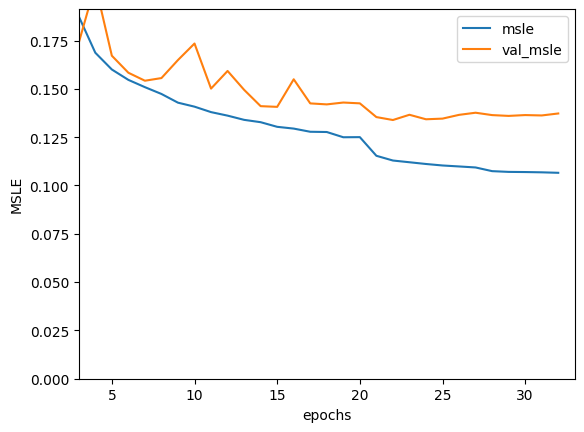

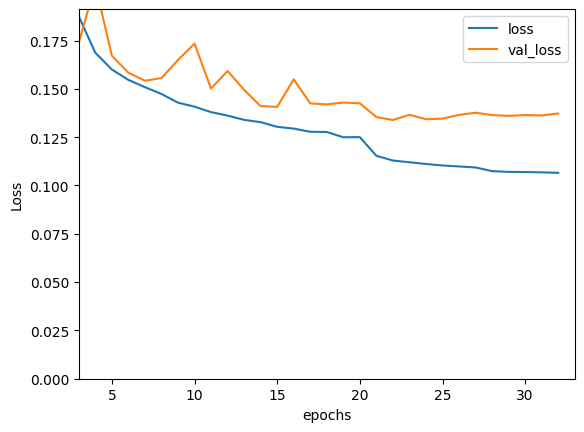

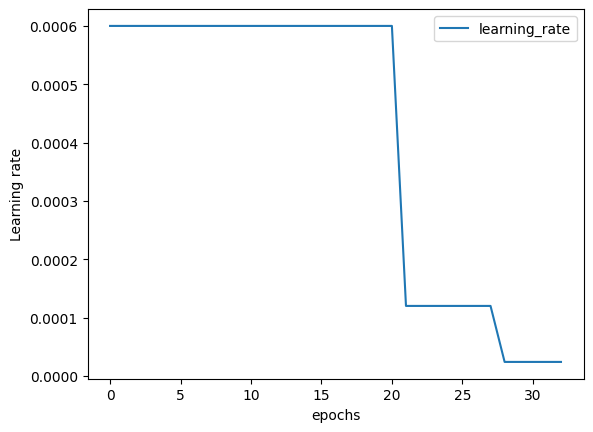

In [ ]:
# Plot learning curves

if TRAINING and NN:
    history_fil = {key: history.history[key] for key in ['msle', 'val_msle']}
    history_fil2 = {key: history.history[key] for key in ['loss', 'val_loss']}
    history_fil3 = {key: history.history[key] for key in ['learning_rate']}

    pd.DataFrame(history_fil).plot()
    plt.ylabel("MSLE")
    plt.xlabel("epochs")
    plt.axis([3, len(history_fil['val_msle']), 0, history_fil['val_msle'][3]+0.1*history_fil['val_msle'][3]])
    pd.DataFrame(history_fil2).plot()
    plt.ylabel("Loss")
    plt.xlabel("epochs")
    plt.axis([3, len(history_fil2['val_loss']), 0, history_fil2['val_loss'][3]+0.1*history_fil2['val_loss'][3]])
    pd.DataFrame(history_fil3).plot()
    plt.ylabel("Learning rate")
    plt.xlabel("epochs")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Axes: title={'center': 'Sales prediction of store 44 for AUTOMOTIVE products'}, xlabel='date'>

<Figure size 640x480 with 0 Axes>

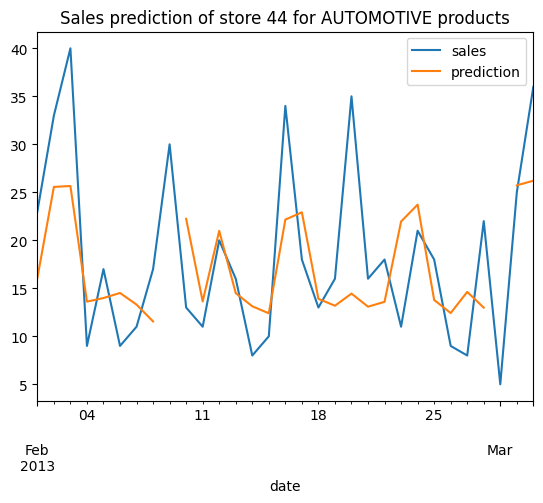

<Figure size 640x480 with 0 Axes>

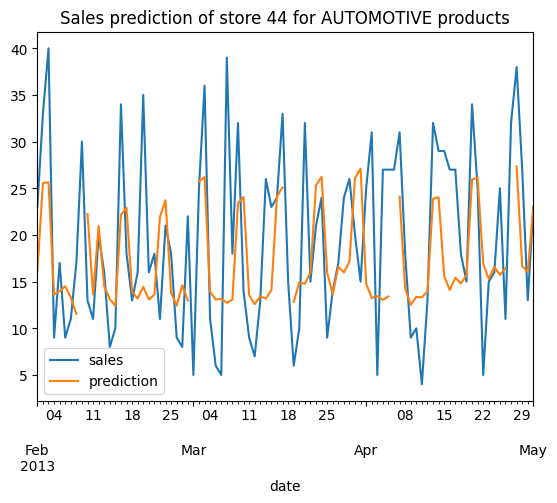

<Figure size 640x480 with 0 Axes>

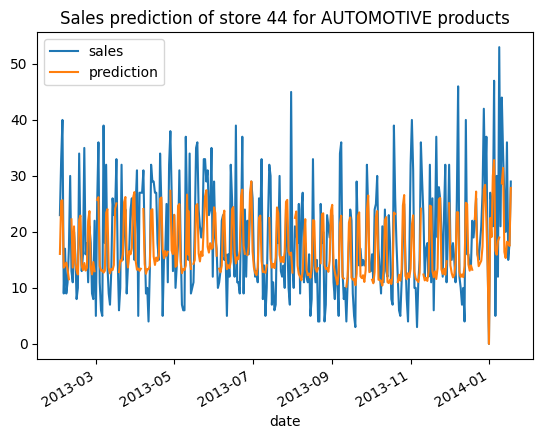

In [ ]:
# Plot sales for selected store and product family

store = 44
family = 'AUTOMOTIVE'
store_train = f'store_nbr_{store}'
family_train = f'family_{family}'
datat_fil = datat[((datat['store_nbr']==store) & (datat['family']==family))]
train_feat_fil = train_feat[((train_feat[store_train]==True) & (train_feat[family_train]==True))]
train_pred_fil = pd.DataFrame(model_nn.predict(train_feat_fil), columns=['prediction'], index=train_feat_fil.index)
datat_fil = datat_fil.merge(train_pred_fil, how='left', left_index=True, right_index=True)
datat_fil.set_index(['date'], inplace=True)

start = 31
plt.figure()
datat_fil[['sales', 'prediction']][start:31+start].plot(title='Sales prediction of store {} for {} products'.format(str(store), family))
plt.figure()
datat_fil[['sales', 'prediction']][start:90+start].plot(title='Sales prediction of store {} for {} products'.format(str(store), family))
plt.figure()
datat_fil[['sales', 'prediction']][start:356+start].plot(title='Sales prediction of store {} for {} products'.format(str(store), family))

# 6. Submission

In [ ]:
models=[]
if ML:
    models = models + ['svc', 'rfc', 'kneigh', 'gbc', 'xgb']
if NN:
    models = models + ['nn']

submission_all = pd.DataFrame(data[['id']])
for mod in models:
    model = globals()[f'model_{mod}']
    submission = pd.DataFrame(data[['id']])
    if mod == 'nn':
        predictions = np.stack([model(test_feat, training=True) for sample in range(200)])
        prediction = predictions.mean(axis=0)
    else:
        prediction = model.predict(test_feat)
    test_prediction = pd.DataFrame(prediction, columns=['sales'])
    submission = submission.merge(test_prediction, how='left', left_index=True, right_index=True)
    submission.to_csv(f'submission_{mod}.csv', index=False)
    submission_all[[mod]] = submission[['sales']]
if ML and NN:
    submission_all[['sales']] = pd.DataFrame((submission_all[['svc', 'rfc', 'gbc', 'xgb', 'nn']].sum(axis=1)/5))
    submission_all[['id', 'sales']].to_csv('submission_avg.csv', index=False)

# 7. Experimenting code

In [ ]:
import joblib
import os

✅ Saved Neural Network model: model_nn.keras
All models saved to /kaggle/working/models/ ✅


In [ ]:
os.makedirs('/kaggle/working/models', exist_ok=True)

In [ ]:
# 7.1. Save ML models
if ML:
    for mod in ['svr', 'rfr', 'kneigh', 'gbr', 'xgb']:
        if mod in globals():
            joblib.dump(globals()[f'model_{mod}'], f'/kaggle/working/models/{mod}.joblib')
            print(f"Saved ML model: {mod}")

In [ ]:
# 7.2. Save Neural Network model in Keras format
if NN:
    model_nn.save('/kaggle/working/models/model_nn.keras')
    print("Saved Neural Network model: model_nn.keras")

Now, all models saved to /kaggle/working/models/

In [ ]:
inp = tf.keras.Input(shape=(len(train_feat.columns),), name='input')
print(inp)

<KerasTensor shape=(None, 103), dtype=float32, sparse=False, name=input>
